# Vegetation Data Access

Accessing NDVI data

# STEP 2: AppEEARS API

# STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [1]:
%store -r

Unable to restore variable 'ndvi_diff', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


In [2]:
id = 'shortcourse'
site_name = 'Tubarjal Valley Saudi Arabia'
project_name = 'Tubarjal Valley Saudi Arabia Irrigation'
bounda = 'groundwater irrigation'
start_year = 2001
end_year = 2022 
event_year = 2012
download_key = 'tubarjal-vegetation'

You will also need to import any libraries you are using in this
notebook, since they won’t carry over from the previous notebook:

In [3]:
# Import libraries
import json
import os
import pathlib
import shutil
from glob import glob

import earthpy.api.appeears as eaapp
import earthpy
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

## Exploring the AppEEARS API for NASA Earthdata access

Before you get started with the data download today, you will need a
free [NASA Earthdata account](https://urs.earthdata.nasa.gov/home) if
you don’t have one already!

Over the next four cells, you will download MODIS NDVI data for the
study period. MODIS is a multispectral instrument that measures Red and
NIR data (and so can be used for NDVI). There are two MODIS sensors on
two different platforms: satellites Terra and Aqua.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p><a href="https://modis.gsfc.nasa.gov/">Learn more about MODIS
datasets and the science they support</a></p></div></div>

Since we’re asking for a special download that only covers our study
area, we can’t just find a link to the data - we have to negotiate with
the data server. We’re doing this using the
[APPEEARS](https://appeears.earthdatacloud.nasa.gov/api/) API
(Application Programming Interface). The API makes it possible for you
to request data using code. You can use code from the `earthpy` library
to handle the API request.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Often when we want to do something more complex in coding we find an
example and modify it. This download code is already almost a working
example. Your task will be:</p>
<ol type="1">
<li>Replace the start and end dates in the task parameters. Download
data from July, when greenery is at its peak in the Northern
Hemisphere.</li>
<li>Replace the year range. You should get 3 years before and after the
event so you can see the change!</li>
<li>Replace <code>gdf</code> with the name of <strong>your</strong> site
geodataframe.</li>
<li><strong>Enter your NASA Earthdata username and password when
prompted.</strong> The prompts can be a little hard to see – look at the
top of your screen!</li>
</ol></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What would the product and layer name be if you were trying to
download Landsat Surface Temperature Analysis Ready Data (ARD) instead
of MODIS NDVI?</p></div></div>

> **Important**
>
> It can take some time for Appeears to process your request - anything
> from a few minutes to a few hours depending on how busy they are. You
> can check your progress by:
>
> 1.  Going to the [Appeears
>     webpage](https://appeears.earthdatacloud.nasa.gov/)
> 2.  Clicking the `Explore` tab
> 3.  Logging in with your Earthdata account

In [4]:
tubarjal_prov_osm_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

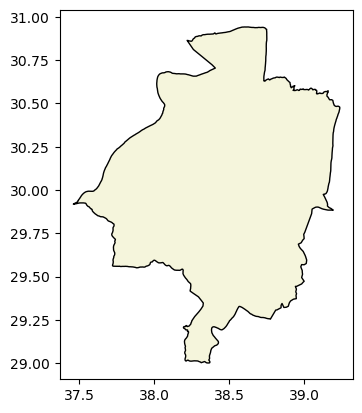

In [5]:
tubarjal_prov_osm_gdf.plot(color='beige', edgecolor='black')

In [6]:
# Fix the polygon
tubarjal_prov_osm_gdf = tubarjal_prov_osm_gdf.to_crs("EPSG:4326").dissolve()
tubarjal_prov_osm_gdf

,geometry,admin_level,boundary,type,name,name:ar,name:en,place,wikidata,wikipedia
0,"POLYGON ((37.45751 29.92079, 37.45745 29.92187...",6,administrative,boundary,محافظة طبرجل,محافظة طبرجل,Tubarjal,province,Q7672929,en:Tabarjal


In [10]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key=download_key,
    project=project,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="06-01",
    end_date="09-01",
    recurring=True,
    year_range=[start_year, end_year],
    polygon=tubarjal_prov_osm_gdf
)
# Download the prepared download -- this can take some time!
ndvi_downloader.download_files(cache=True)

Credentials found using 'env' backend.


## Putting it together: Working with multi-file raster datasets in Python

Now you need to load all the downloaded files into Python. You may have
noticed that the \`earthpy.appears module gives us all the downloaded
file names…but only some of those are the NDVI files we want while
others are quality files that tell us about the confidence in the
dataset. For now, the files we want all have “NDVI” in the name.

Let’s start by getting all the NDVI file names. You will also need to
extract the date from the filename. Check out [the lesson on getting
information from filenames in the
textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/loops/data-workflows-with-loops/).
We’re using a slightly different method here (the `.rglob()` or
**recursive** glob method, which searchs all the directories nested
inside the path), but the principle is the same.

> **GOTCHA ALERT!**
>
> `glob` doesn’t necessarily find files in the order you would expect.
> Make sure to **sort** your file names like it says in the textbook.

In [4]:
# Get a sorted list of NDVI tif file paths
ndvi_paths = sorted(list(project.project_dir.rglob('*NDVI*.tif')))

# Display the first and last three files paths to check the pattern
ndvi_paths[:3], ndvi_paths[-3:]

([PosixPath('/workspaces/data/tubarjal_dir/tubarjal-vegetation/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001145000000_aid0001.tif'),
  PosixPath('/workspaces/data/tubarjal_dir/tubarjal-vegetation/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001161000000_aid0001.tif'),
  PosixPath('/workspaces/data/tubarjal_dir/tubarjal-vegetation/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001177000000_aid0001.tif')],
 [PosixPath('/workspaces/data/tubarjal_dir/tubarjal-vegetation/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2022209000000_aid0001.tif'),
  PosixPath('/workspaces/data/tubarjal_dir/tubarjal-vegetation/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2022225000000_aid0001.tif'),
  PosixPath('/workspaces/data/tubarjal_dir/tubarjal-vegetation/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2022241000000_aid0001.tif')])

### Repeating tasks in Python

Now you should have a few dozen files! For each file, you need to:

-   Load the file in using the `rioxarray` library
-   Get the date from the file name
-   Add the date as a dimension coordinate
-   Give your data variable a name

You don’t want to write out the code for each file! That’s a recipe for
**copy pasta** and errors. Luckily, Python has tools for doing similar
tasks repeatedly. In this case, you’ll use one called a `for` loop.

There’s some code below that uses a `for` loop in what is called an
**accumulation pattern** to process each file. That means that you will
save the results of your processing to a list each time you process the
files, and then merge all the arrays in the list.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ul>
<li>Look at the file names. How many characters from the end is the
date? <code>doy_start</code> and <code>doy_end</code> are used to
extract the day of the year (doy) from the file name. You will need to
count characters from the end and change the values to get the right
part of the file name. HINT: the index -1 in Python means the last
value, -2 second-to-last, and so on.</li>
<li>Replace any required variable names with your chosen variable
names</li>
</ul></div></div>

In [5]:
doy_start = -25
doy_end = -19

# Loop through each NDVI image
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path.name[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, mask_and_scale=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Prepare for concatenation
    ndvi_das.append(da)

len(ndvi_das)

154

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Next, stack your arrays by date into a time series:</p>
<ol type="1">
<li>Modify the code to match your prior workflow steps and to use
descriptive variable names</li>
<li>Replace <code>coordinate_name</code> with the actual name of the
coordinate you want to build up.</li>
</ol></div></div>

In [6]:
# Combine NDVI images from all dates
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da

: 

In [ ]:
# Compute the difference in NDVI before and after
ndvi_diff = (
    ndvi_da
        .sel(date=slice('2012', '2022'))
        .mean('date')
        .NDVI 
   - ndvi_da
        .sel(date=slice('2001', '2012'))
        .mean('date')
        .NDVI
)
# Plot the difference
(
    ndvi_diff.hvplot(x='x', y='y', cmap='PiYG', geo=True)
    *
    tubarjal_prov_osm_gdf.hvplot(geo=True, fill_color=None, line_color='black')
)


: 

In [9]:
# Apply NDVI threshold
# Create a composite of NDVI values for each year
composite_da = (
    ndvi_da
    .groupby('date.year')
    .mean(dim=['date'])
)

In [10]:
# Count number of vegetated pixels each year
annual_veg_da = (
    composite_da
    # Identify vegetated pixels
    .where(composite_da>0.3)
    # Count pixels in each annual image
    .count(dim=['x', 'y'])
)
annual_veg_da

<xarray.Dataset> Size: 368B
Dimensions:      (year: 22)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * year         (year) int64 176B 2001 2002 2003 2004 ... 2019 2020 2021 2022
Data variables:
    NDVI         (year) int64 176B 5409 6333 8329 8780 ... 31267 34371 36169

In [11]:
# Plot number of vegetated pixels over time

(
    annual_veg_da
    .NDVI
    .hvplot(
        title=f'Vegetation over time in {site_name}',
        ylabel='Vegetated pixels',
        xlabel='Year')
)



:Curve   [year]   (NDVI)

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [12]:
%store ndvi_diff

Stored 'ndvi_diff' (DataArray)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!